In [1]:
import datetime as dt

import torch.nn
import yfinance as yf
import pandas as pd

SPY_TOP_10_SYMBOLS = ["AAPL", "MSFT", "AMZN", "META", "GOOGL", "GOOG", "BRK-B", "TSLA", "NVDA", "JPM"]
START = dt.datetime(2022, 1, 31)
END = dt.datetime(2022, 11, 20)


def fetch_stocks(symbols):
    prices = yf.download(SYMBOLS, start=START, end=END)
    for symbol in symbols:
        prices.index = prices.index.map(str)
        stock_df = prices.T.loc[(slice(None), symbol), :]\
            .swaplevel(i=0, j=1).xs(symbol, level=0).T.dropna(how="all")
        stock_df.to_csv(f"data/{symbol}.csv")


def load_dataset():
    all_stocks_data = []
    for symbol in SPY_TOP_10_SYMBOLS:
        _data = pd.read_csv(f"./data/{symbol}.csv")
        _data.index = pd.to_datetime(_data["Date"])
        _data["Symbol"] = symbol
        _data["Adj Close"] /= _data["Adj Close"][0]
        all_stocks_data.append(_data.drop("Date", axis=1))
        break

    combined = pd.concat(all_stocks_data)
    combined["Symbol"] = combined["Symbol"].astype("category").cat.codes

    return combined


SYMBOLS = ["AAPL", "MSFT", "AMZN", "META", "GOOGL", "GOOG", "BRK-B", "TSLA", "NVDA", "JPM"]

def format_dataset():
    all_stocks_data = []
    prices = yf.download(SYMBOLS, start=START, end=END)

    for symbol in SYMBOLS:
        prices.index = prices.index.map(str)
        stock_df = prices.T.loc[(slice(None), symbol), :]\
            .swaplevel(i=0, j=1).xs(symbol, level=0).T.dropna(how="all")
        stock_df["symbol"] = symbol
        stock_df["date"] = pd.to_datetime(stock_df.index)
        stock_df["price"] = stock_df["Adj Close"]
        stock_df = stock_df[["symbol", "date", "price"]].reset_index(drop=True)
        all_stocks_data.append(stock_df)

    combined = pd.concat(all_stocks_data)
    # combined.symbol = combined.symbol.astype("category").cat.codes
    return combined

In [2]:
stock_data = format_dataset()

[*********************100%***********************]  10 of 10 completed


In [3]:
stock_data

,symbol,date,price
0,AAPL,2022-01-31,173.771469
1,AAPL,2022-02-01,173.602448
2,AAPL,2022-02-02,174.825348
3,AAPL,2022-02-03,171.902313
4,AAPL,2022-02-04,171.613632
...,...,...,...
199,JPM,2022-11-14,133.910004
200,JPM,2022-11-15,132.940002
201,JPM,2022-11-16,133.119995
202,JPM,2022-11-17,132.539993


In [16]:
from matplotlib import pyplot as plt
from darts import TimeSeries

stock_data.index = pd.to_datetime(stock_data.date)
trimmed = stock_data.where(stock_data.symbol == "AMZN").dropna()["price"]
# grouped = stock_data.groupby("symbol")
ts = TimeSeries.from_series(trimmed, fill_missing_dates=True, freq='D', fillna_value=0)

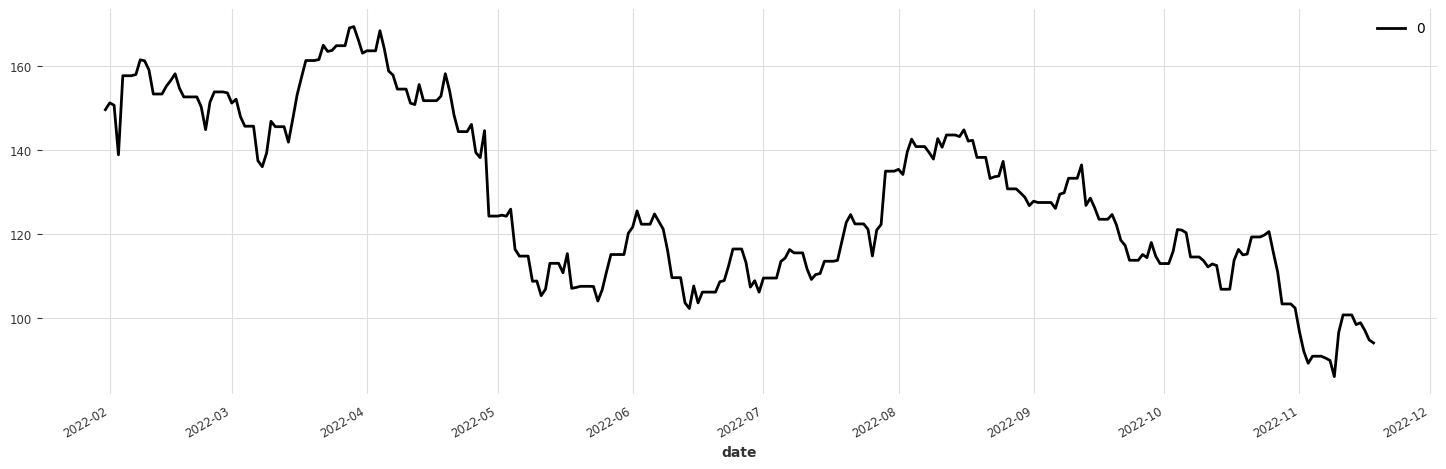

In [17]:
temp = ts.pd_series()
previous = 0

for date in temp.index:
    if temp[date] == 0:
        temp[date] = previous
    else:
        previous = temp[date]

ts = TimeSeries.from_series(temp, freq='D')
plt.figure(100, figsize=(18, 5))
ts.plot()

In [43]:
# from darts.dataprocessing.transformers import Scaler
# from darts.utils.timeseries_generation import datetime_attribute_timeseries
#
# split = pd.Timestamp(dt.datetime(2022, 9, 30))
# ts_train, ts_test = ts.split_after(split)
#
# transformer = Scaler()
# ts_ttrain = transformer.fit_transform(ts_train)
# ts_ttest = transformer.transform(ts_test)
#
# ts_t = transformer.transform(ts)

In [42]:
# import numpy as np
#
# cov = datetime_attribute_timeseries(ts, attribute="month", one_hot=False)
# cov = cov.stack(datetime_attribute_timeseries(ts, "day", one_hot=False))
# cov = cov.stack(TimeSeries.from_times_and_values(
#     times=ts.time_index,
#     values=np.arange(len(ts)),
#     columns=["linear_increase"]
# )).astype(np.float32)
#
# train_cov, test_cov = cov.split_after(split)
# scaler = Scaler()
# scaler.fit(train_cov)
# t_cov = scaler.transform(cov)

In [7]:
EPOCHS = 300
INLEN = 64
HIDDEN = 128
LSTMLAYERS = 2
ATTHEADS = 1
DROPOUT = 0.1
BATCH = 64

N_FC = 4           # default forecast horizon
RAND = 42           # set random state
N_SAMPLES = 50     # number of times a prediction is sampled from a probabilistic model
N_JOBS = -1          # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.05, 0.1, 0.2, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99]

TRAIN = "19571201"  # train/test split
MSEAS = 60          # max seasonality to check: months
ALPHA = 0.05        # significance level for seasonality test
FIGSIZE = (9, 6)

qL1, qL2, qL3 = 0.01, 0.05, 0.10        # percentiles of predictions: lower bounds
qU1, qU2, qU3 = 1-qL1, 1-qL2, 1-qL3     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'
label_q3 = f'{int(qU3 * 100)} / {int(qL3 * 100)} percentile band'

In [8]:
def reset_model():
    return TFTModel(
        input_chunk_length=INLEN,
        output_chunk_length=N_FC,
        hidden_size=HIDDEN,
        lstm_layers=LSTMLAYERS,
        num_attention_heads=ATTHEADS,
        dropout=DROPOUT,
        batch_size=BATCH,
        n_epochs=EPOCHS,
        likelihood=QuantileRegression(quantiles=QUANTILES),
        loss_fn=MSELoss(),
        random_state=RAND,
        force_reset=True
    )

In [22]:
def get_data(ticker):
    prices = stock_data.where(stock_data.symbol == ticker).dropna().price
    time_series = TimeSeries.from_series(prices, fill_missing_dates=True, freq='D', fillna_value=0)

    temp = time_series.pd_series()
    prev = 0

    for i in temp.index:
        if temp[i] == 0:
            temp[i] = prev
        else:
            prev = temp[i]

    time_series = TimeSeries.from_series(temp, freq='D')
    train, test = time_series.split_after(split)
    transformer = Scaler()
    train, test = transformer.fit_transform(train), transformer.transform(test)

    covariates = datetime_attribute_timeseries(time_series, "month")
    covariates = covariates.stack(datetime_attribute_timeseries(time_series, "day"))
    covariates = covariates.stack(TimeSeries.from_times_and_values(
        times=time_series.time_index, values=np.arange(len(time_series)), columns=["linear_increase"]
    )).astype(np.float32)

    train_cov, test_cov = covariates.split_after(split)
    scaler = Scaler()
    scaler.fit(train_cov)
    t_cov = scaler.transform(covariates)

    return train, t_cov, test, transformer, time_series

In [12]:
def model_ticker(ticker):
    model = reset_model()
    s, fc, t, _ = get_data(ticker)
    #
    model.fit(series=s, future_covariates=fc)
    return model

In [14]:
stock_models = []

for sym in SYMBOLS:
    m = model_ticker(sym)
    stock_models.append(m)
# ts_predict = model.predict(len(ts_test))
#
# plt.figure(100, figsize=(18, 5))
# ts.plot(label="actual")
# ts_predict.plot(label="TFT")
#
# plt.legend()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0     
1  | train_metrics                     | MetricCollection                 | 0     
2  | val_metrics                       | MetricCollection                 | 0     
3  | input_embeddings                  | _MultiEmbedding                  | 0     
4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
5  | encoder_vsn                       | _VariableSelectionNetwork        | 13.1 K
6  | decoder_vsn                       | _VariableSelectionNetwork        | 9.8 K 
7  | static_context_grn                | _GatedResidualNetwork            | 66.3 K
8  | static_cont

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0     
1  | train_metrics                     | MetricCollection                 | 0     
2  | val_metrics                       | MetricCollection                 | 0     
3  | input_embeddings                  | _MultiEmbedding                  | 0     
4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
5  | encoder_vsn                       | _VariableSelectionNetwork        | 13.1 K
6  | decoder_vsn                       | _VariableSelectionNetwork        | 9.8 K 
7  | static_context_grn                | _GatedRes

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0     
1  | train_metrics                     | MetricCollection                 | 0     
2  | val_metrics                       | MetricCollection                 | 0     
3  | input_embeddings                  | _MultiEmbedding                  | 0     
4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
5  | encoder_vsn                       | _VariableSelectionNetwork        | 13.1 K
6  | decoder_vsn                       | _VariableSelectionNetwork        | 9.8 K 
7  | static_context_grn                | _GatedRes

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0     
1  | train_metrics                     | MetricCollection                 | 0     
2  | val_metrics                       | MetricCollection                 | 0     
3  | input_embeddings                  | _MultiEmbedding                  | 0     
4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
5  | encoder_vsn                       | _VariableSelectionNetwork        | 13.1 K
6  | decoder_vsn                       | _VariableSelectionNetwork        | 9.8 K 
7  | static_context_grn                | _GatedRes

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0     
1  | train_metrics                     | MetricCollection                 | 0     
2  | val_metrics                       | MetricCollection                 | 0     
3  | input_embeddings                  | _MultiEmbedding                  | 0     
4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
5  | encoder_vsn                       | _VariableSelectionNetwork        | 13.1 K
6  | decoder_vsn                       | _VariableSelectionNetwork        | 9.8 K 
7  | static_context_grn                | _GatedRes

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0     
1  | train_metrics                     | MetricCollection                 | 0     
2  | val_metrics                       | MetricCollection                 | 0     
3  | input_embeddings                  | _MultiEmbedding                  | 0     
4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
5  | encoder_vsn                       | _VariableSelectionNetwork        | 13.1 K
6  | decoder_vsn                       | _VariableSelectionNetwork        | 9.8 K 
7  | static_context_grn                | _GatedRes

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0     
1  | train_metrics                     | MetricCollection                 | 0     
2  | val_metrics                       | MetricCollection                 | 0     
3  | input_embeddings                  | _MultiEmbedding                  | 0     
4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
5  | encoder_vsn                       | _VariableSelectionNetwork        | 13.1 K
6  | decoder_vsn                       | _VariableSelectionNetwork        | 9.8 K 
7  | static_context_grn                | _GatedRes

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0     
1  | train_metrics                     | MetricCollection                 | 0     
2  | val_metrics                       | MetricCollection                 | 0     
3  | input_embeddings                  | _MultiEmbedding                  | 0     
4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
5  | encoder_vsn                       | _VariableSelectionNetwork        | 13.1 K
6  | decoder_vsn                       | _VariableSelectionNetwork        | 9.8 K 
7  | static_context_grn                | _GatedRes

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0     
1  | train_metrics                     | MetricCollection                 | 0     
2  | val_metrics                       | MetricCollection                 | 0     
3  | input_embeddings                  | _MultiEmbedding                  | 0     
4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
5  | encoder_vsn                       | _VariableSelectionNetwork        | 13.1 K
6  | decoder_vsn                       | _VariableSelectionNetwork        | 9.8 K 
7  | static_context_grn                | _GatedRes

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0     
1  | train_metrics                     | MetricCollection                 | 0     
2  | val_metrics                       | MetricCollection                 | 0     
3  | input_embeddings                  | _MultiEmbedding                  | 0     
4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
5  | encoder_vsn                       | _VariableSelectionNetwork        | 13.1 K
6  | decoder_vsn                       | _VariableSelectionNetwork        | 9.8 K 
7  | static_context_grn                | _GatedRes

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


In [ ]:
def plot_predict(ts_actual, ts_test, ts_pred):

    ## plot time series, limited to forecast horizon
    plt.figure(figsize=FIGSIZE)

    ts_actual.plot(label="actual")                                       # plot actual

    # ts_pred.plot(low_quantile=qL1, high_quantile=qU1, label=label_q1)    # plot U1 quantile band
    #ts_pred.plot(low_quantile=qL2, high_quantile=qU2, label=label_q2)   # plot U2 quantile band
    # ts_pred.plot(low_quantile=qL3, high_quantile=qU3, label=label_q3)    # plot U3 quantile band
    ts_pred.plot(central_quantile="mean", label="prediction")                 # plot "mean" or median=0.5

    plt.title("TFT: test set")
    plt.legend()

In [20]:
_, _, t, transformer, ts = get_data("AAPL")
m = stock_models[0]

ts_predict = m.predict(n=len(t), num_samples=N_SAMPLES, n_jobs=N_JOBS)
ts_predict = transformer.inverse_transform(ts_predict)
plot_predict(ts, t, ts_predict)

In [40]:
# ts_tpredict = model.predict(n=len(ts_test), num_samples=N_SAMPLES, n_jobs=N_JOBS)

In [17]:
from darts.metrics import mape


# testing: helper function: plot predictions
def plot_predict(ts_actual, ts_test, ts_pred):

    ## plot time series, limited to forecast horizon
    plt.figure(figsize=FIGSIZE)

    ts_actual.plot(label="actual")                                       # plot actual

    # ts_pred.plot(low_quantile=qL1, high_quantile=qU1, label=label_q1)    # plot U1 quantile band
    #ts_pred.plot(low_quantile=qL2, high_quantile=qU2, label=label_q2)   # plot U2 quantile band
    # ts_pred.plot(low_quantile=qL3, high_quantile=qU3, label=label_q3)    # plot U3 quantile band
    ts_pred.plot(central_quantile="mean", label="prediction")                 # plot "mean" or median=0.5

    plt.title("TFT: test set")
    plt.legend()
#
#
#  # testing: call helper function: plot predictions
# ts_pred = transformer.inverse_transform(ts_tpredict)
# plot_predict(ts, ts_test, ts_pred)

16.54960505301971

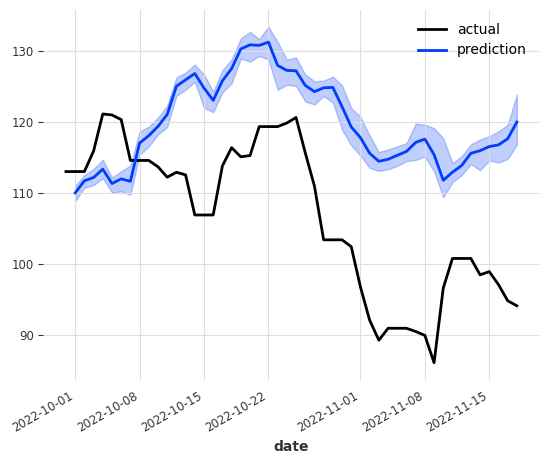

In [186]:
# import math
#
# ts[split:].plot(label="actual")
# ts_pred.plot(central_quantile="mean", label="prediction")
#
# pred = ts_pred.quantile_df()
# pred = pred[pred.columns[0]]
#
# from sklearn.metrics import mean_squared_error
#
# RMSE = math.sqrt(mean_squared_error(ts[split:].pd_series()[1:].values, pred.values))
# RMSE

AMZN: RMSE - 16.55

In [4]:
stock_data.index = pd.to_datetime(stock_data.date)
split = pd.Timestamp(dt.datetime(2022, 9, 30))

In [5]:
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression
from torch.nn import MSELoss
from matplotlib import pyplot as plt
from darts import TimeSeries
import numpy as np
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

C:\Users\Connor\Documents\School\CS7637\venv\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [13]:
# stock_models = []
#
# # for symbol in SYMBOLS:
# #     model, series, covariate = process(symbol)
# #     model.fit(series=series, future_covariates=covariate)
# #     stock_models.append(model)
# #     break
#
# m = process("AAPL")
# # m.fit(series=s, future_covariates=c)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, best=False)`. Finally, train the model with `model.fit(..., epochs=new_epochs)` where `new_epochs` is the sum of (epochs already trained + some additional epochs).

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0     
1  | train_metrics                     | MetricCollection                 | 0     
2  | val_metrics                       | MetricCollection                 | 0     
3  | input_emb

Training: 0it [00:00, ?it/s]

C:\Users\Connor\Documents\School\CS7637\venv\lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
